In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Analyzing the Heston Medel

In [2]:
from heston_model import HestonModel, HestonParameters

In [3]:
sns.set_style("whitegrid")

# 1. Initialize model with parameters that strictly satisfy the Feller condition
# Feller: 2*kappa*theta > sigma^2 
params = HestonParameters(
    kappa=1.2,    # Moderate mean reversion
    theta=0.10,   # Long-term variance (32% volatility)
    sigma=0.3,    # Volatility of variance
    rho=-0.8,     # Strong leverage effect (more negative ρ implies a stronger leverage effect.)
    v0=0.10,      # Initial variance matching long-term level
    mu=0.1        # Drift rate
)

In [4]:
# Verify Feller condition
feller_value = 2 * params.kappa * params.theta
sigma_squared = params.sigma ** 2
print("\nFeller Condition Analysis:")
print(f"2κθ = {feller_value:.3f}")
print(f"σ² = {sigma_squared:.3f}")
print(f"Feller condition {'satisfied' if feller_value > sigma_squared else 'not satisfied'}")
print(f"Margin: {feller_value - sigma_squared:.3f}")
print("\nParameter Interpretation:")
print(f"- κ = {params.kappa:.2f}: Moderate mean reversion for persistence and stability")
print(f"- θ = {params.theta:.3f}: Long-term variance (corresponds to {np.sqrt(params.theta)*100:.1f}% volatility)")
print(f"- σ = {params.sigma:.2f}: Volatility of variance")
print(f"- ρ = {params.rho:.1f}: Strong negative correlation captures leverage effect")


Feller Condition Analysis:
2κθ = 0.240
σ² = 0.090
Feller condition satisfied
Margin: 0.150

Parameter Interpretation:
- κ = 1.20: Moderate mean reversion for persistence and stability
- θ = 0.100: Long-term variance (corresponds to 31.6% volatility)
- σ = 0.30: Volatility of variance
- ρ = -0.8: Strong negative correlation captures leverage effect


In [5]:
# define the model
model = HestonModel(params)


In [6]:
# 2. Simulate paths
S0 = 100    # Initial price
T = 5.0     # Total time horizon
N = 1250    # Increased number of time steps
M = 1000    # Number of paths

print("\nSimulating price and variance paths...")
prices, variances = model.simulate_paths(S0, T, N, M, return_vol=True)


Simulating price and variance paths...


In [7]:

# Check for any negative variances in simulation
neg_var_count = np.sum(variances < 0)
if neg_var_count > 0:
    print(f"\nWarning: {neg_var_count} negative variance values detected in simulation")
    print(f"Percentage of negative values: {100 * neg_var_count / variances.size:.4f}%")
else:
    print("\nNo negative variance values detected in simulation")


No negative variance values detected in simulation


In [8]:
def plot_sample_paths(prices, variances, T, N, num_paths=5):
    """Plot sample price and volatility paths."""
    time_points = np.linspace(0, T, N+1)
    plt.figure(figsize=(15, 6))
    
    # Price paths
    plt.subplot(1, 2, 1)
    for i in range(num_paths):
        plt.plot(time_points, prices[i, :], alpha=0.7)
    plt.title('Sample Price Paths')
    plt.xlabel('Time')
    plt.ylabel('Price')
    
    # Volatility paths
    plt.subplot(1, 2, 2)
    for i in range(num_paths):
        plt.plot(time_points, np.sqrt(variances[i, :]), alpha=0.7)
    plt.title('Sample Volatility Paths')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    
    plt.tight_layout()
    plt.show()
    # plt.savefig('figures/sample_paths.png', dpi=300, bbox_inches='tight')
    plt.close()
    # print("Sample paths plot saved as 'figures/sample_paths.png'")

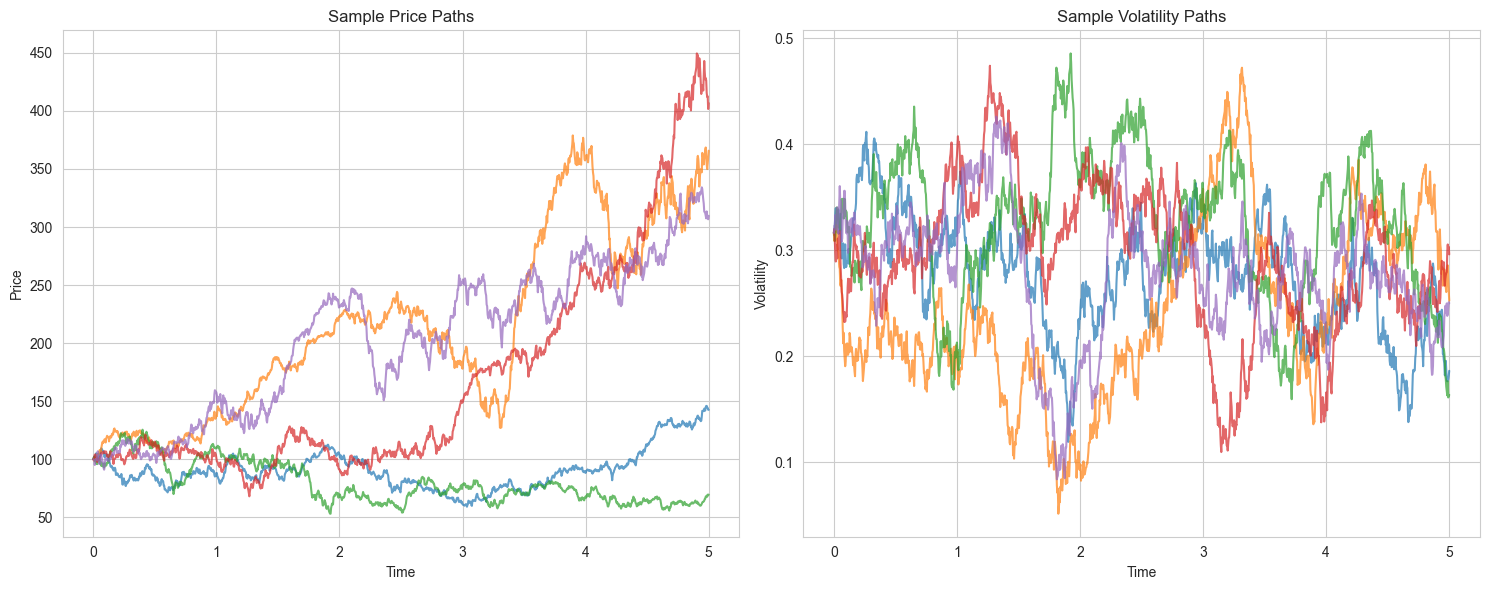

In [12]:
plot_sample_paths(prices, variances, T, N, 5)

In [13]:
def analyze_volatility_clustering(prices: np.ndarray, max_lag: int = 50):
    """
    Analyze volatility clustering through non-linear autocorrelations the return series.
    
    Args:
        prices: 1D array of prices (length N+1)
        max_lag: Max number of lags for autocorrelation (default 50)
        
    Returns:
        Tuple of (lags, autocorrelations) for both absolute and squared returns
    """
    # Calculate returns (log returns)
    returns = np.log(prices[1:] / prices[:-1])  # Shape: (N,)
    
    # Calculate absolute and squared returns
    abs_returns = np.abs(returns)
    squared_returns = returns ** 2

    abs_returns_mean = np.mean(abs_returns)
    squared_returns_mean = np.mean(squared_returns)

    abs_returns_centered = abs_returns - abs_returns_mean
    squared_returns_centered = squared_returns - squared_returns_mean

    abs_returns_var = np.var(abs_returns)
    squared_returns_var = np.var(squared_returns)

    lags = np.arange(max_lag)
    
    # Calculate autocorrelation for both measures
    acf_abs = np.zeros(max_lag)
    acf_squared = np.zeros(max_lag)

    for lag in lags:
        if lag == 0:
            acf_abs[lag] = 1.0
        else:
            acf_abs[lag] = np.mean(abs_returns_centered[lag:] * abs_returns_centered[:-lag]) / abs_returns_var
            acf_squared[lag] = np.mean(squared_returns_centered[lag:] * squared_returns_centered[:-lag]) / squared_returns_var
        
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # ACF of absolute returns
    plt.subplot(2, 1, 1)
    lags_to_plot = lags[1:]
    conf_level = 1.96/np.sqrt(len(abs_returns.flatten()))
    
    plt.fill_between(lags_to_plot, 
                     -conf_level, 
                     conf_level,
                     alpha=0.4,
                     color='orange',
                     label='95% Confidence Interval')
    plt.plot(lags_to_plot, acf_abs[1:], 'bo-', markersize=6, linewidth=2, label='ACF of Absolute Returns')
    plt.title('Autocorrelation of Absolute Returns', fontsize=12, pad=20)
    plt.xlabel('Lag', fontsize=10)
    plt.ylabel('Autocorrelation', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # ACF of squared returns
    plt.subplot(2, 1, 2)
    plt.fill_between(lags_to_plot, 
                     -conf_level, 
                     conf_level,
                     alpha=0.4,
                     color='orange',
                     label='95% Confidence Interval')
    plt.plot(lags_to_plot, acf_squared[1:], 'ro-', markersize=6, linewidth=2, label='ACF of Squared Returns')
    plt.title('Autocorrelation of Squared Returns', fontsize=12, pad=20)
    plt.xlabel('Lag', fontsize=10)
    plt.ylabel('Autocorrelation', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    # plt.savefig('figures/volatility_clustering_acf.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Print statistics
    print("\nVolatility Clustering Analysis:")
    print(f"First-order autocorrelation of absolute returns: {acf_abs[1]:.3f}")
    print(f"First-order autocorrelation of squared returns: {acf_squared[1]:.3f}")
    print(f"Mean autocorrelation of absolute returns (lags 1-10): {np.mean(acf_abs[1:11]):.3f}")
    print(f"Mean autocorrelation of squared returns (lags 1-10): {np.mean(acf_squared[1:11]):.3f}")
    
    # return lags_to_plot, acf_abs, acf_squared

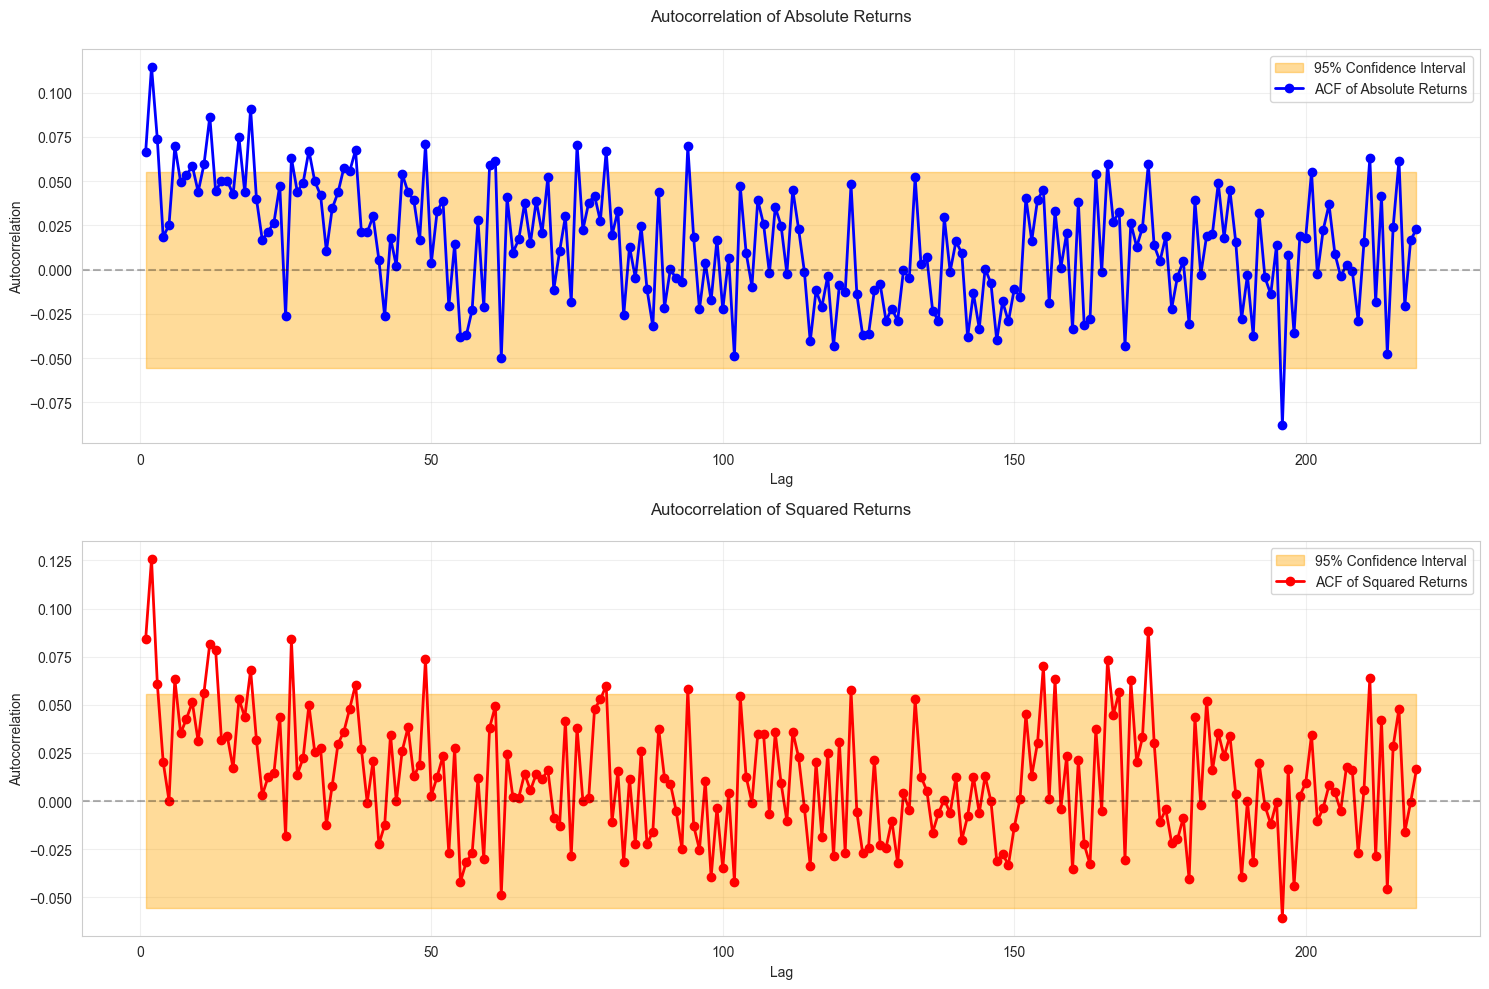


Volatility Clustering Analysis:
First-order autocorrelation of absolute returns: 0.067
First-order autocorrelation of squared returns: 0.084
Mean autocorrelation of absolute returns (lags 1-10): 0.057
Mean autocorrelation of squared returns (lags 1-10): 0.051


In [14]:
analyze_volatility_clustering(prices=prices[0], max_lag=220)

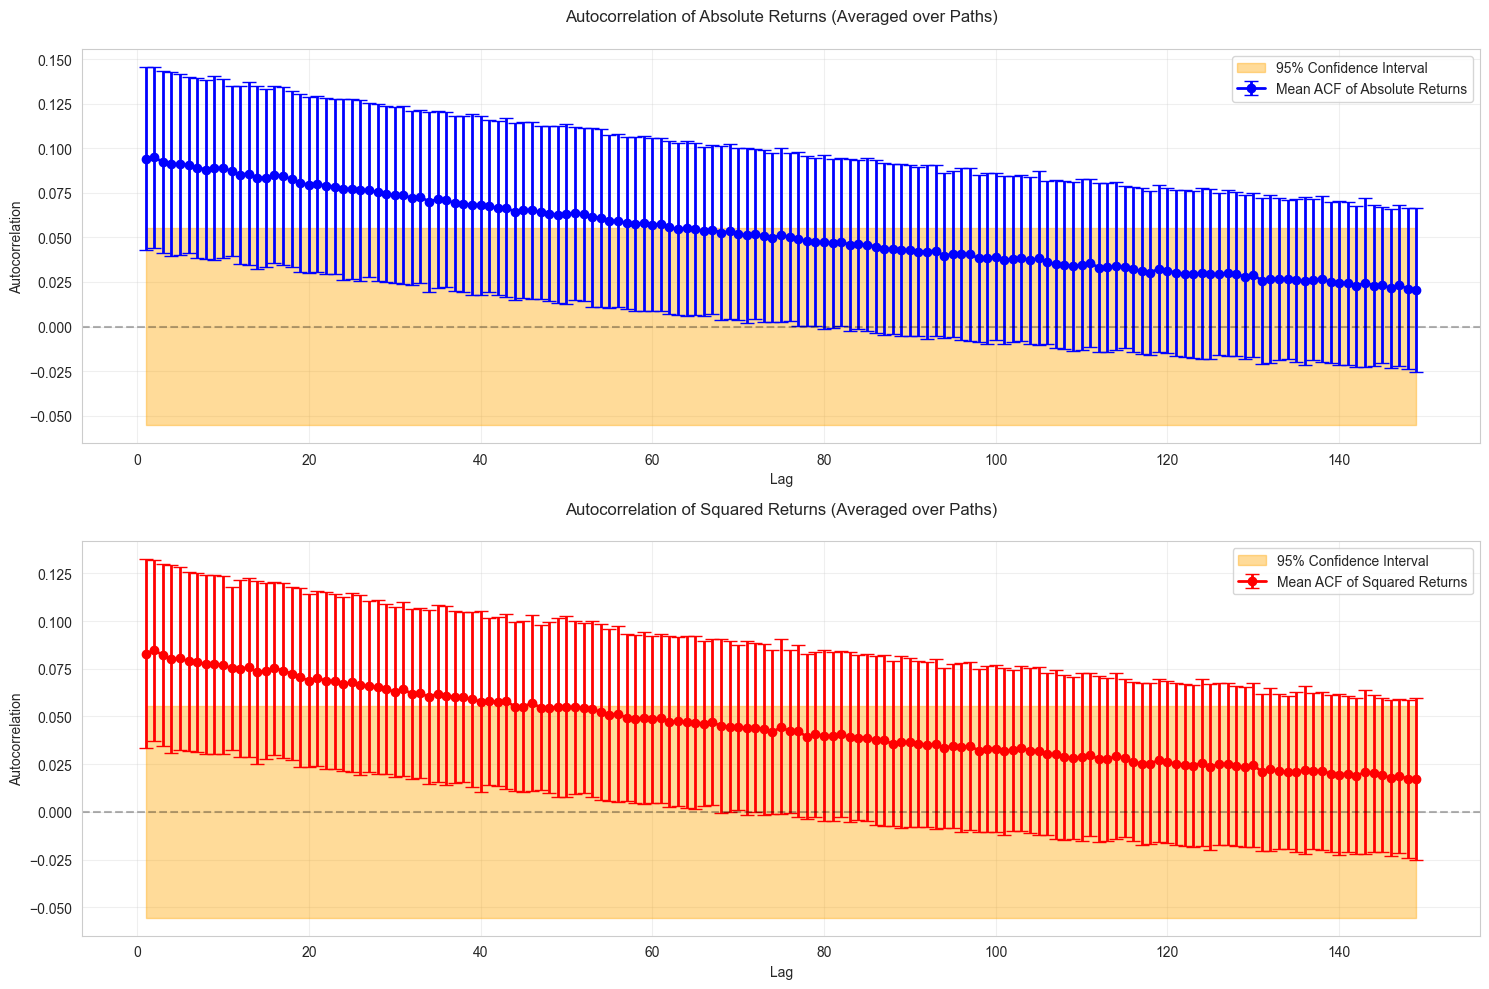


Volatility Clustering Analysis (Averaged over Paths):
First-order autocorrelation of absolute returns: 0.094 ± 0.051
First-order autocorrelation of squared returns: 0.083 ± 0.049
Mean autocorrelation of absolute returns (lags 1-10): 0.091 ± 0.051
Mean autocorrelation of squared returns (lags 1-10): 0.080 ± 0.048


(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149]),
 array([1.        , 0.09414367, 0.0950393 , 0.09224072, 0.09108231,
        0.0910702 , 0.09064638, 0.08914739, 0.08808239, 0.08897763,
        0.0887434 , 0

In [15]:
model.analyze_volatility_clustering(prices, 150)

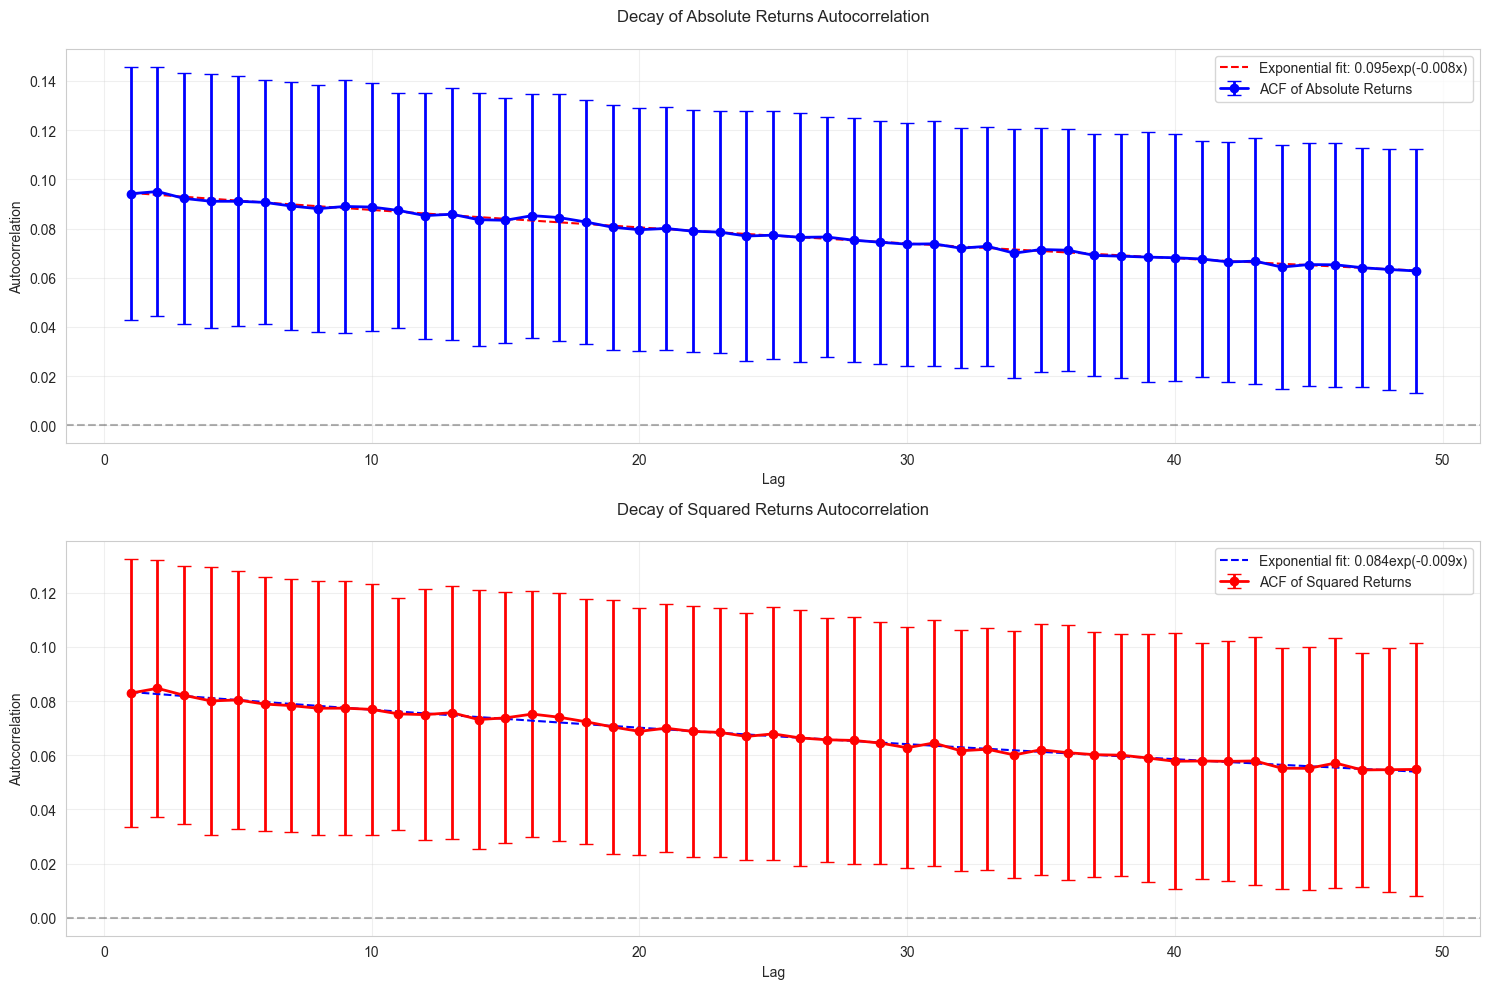

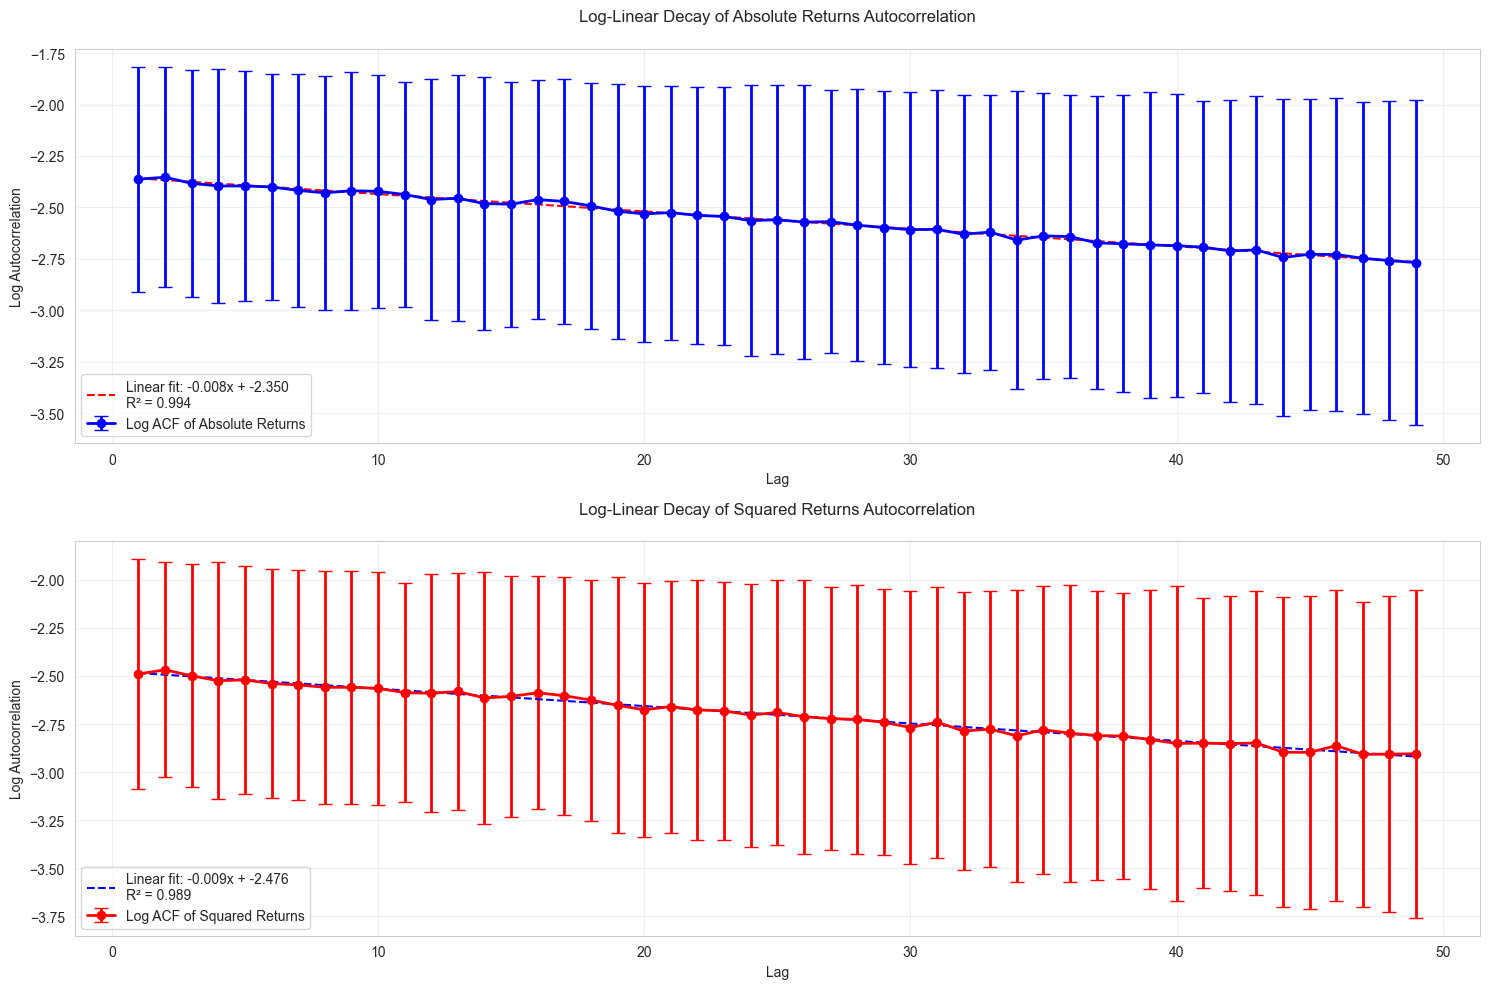


Volatility Clustering Decay Analysis:
Absolute Returns ACF:
Initial decay rate (lag 1): 0.094
Half-life (lag where ACF < 0.5): 1
Exponential decay rate: 0.008
Log-linear decay rate: -0.008
Log-linear R²: 0.994

Squared Returns ACF:
Initial decay rate (lag 1): 0.083
Half-life (lag where ACF < 0.5): 1
Exponential decay rate: 0.009
Log-linear decay rate: -0.009
Log-linear R²: 0.989


In [18]:
model.plot_volatility_decay(prices, T, N)

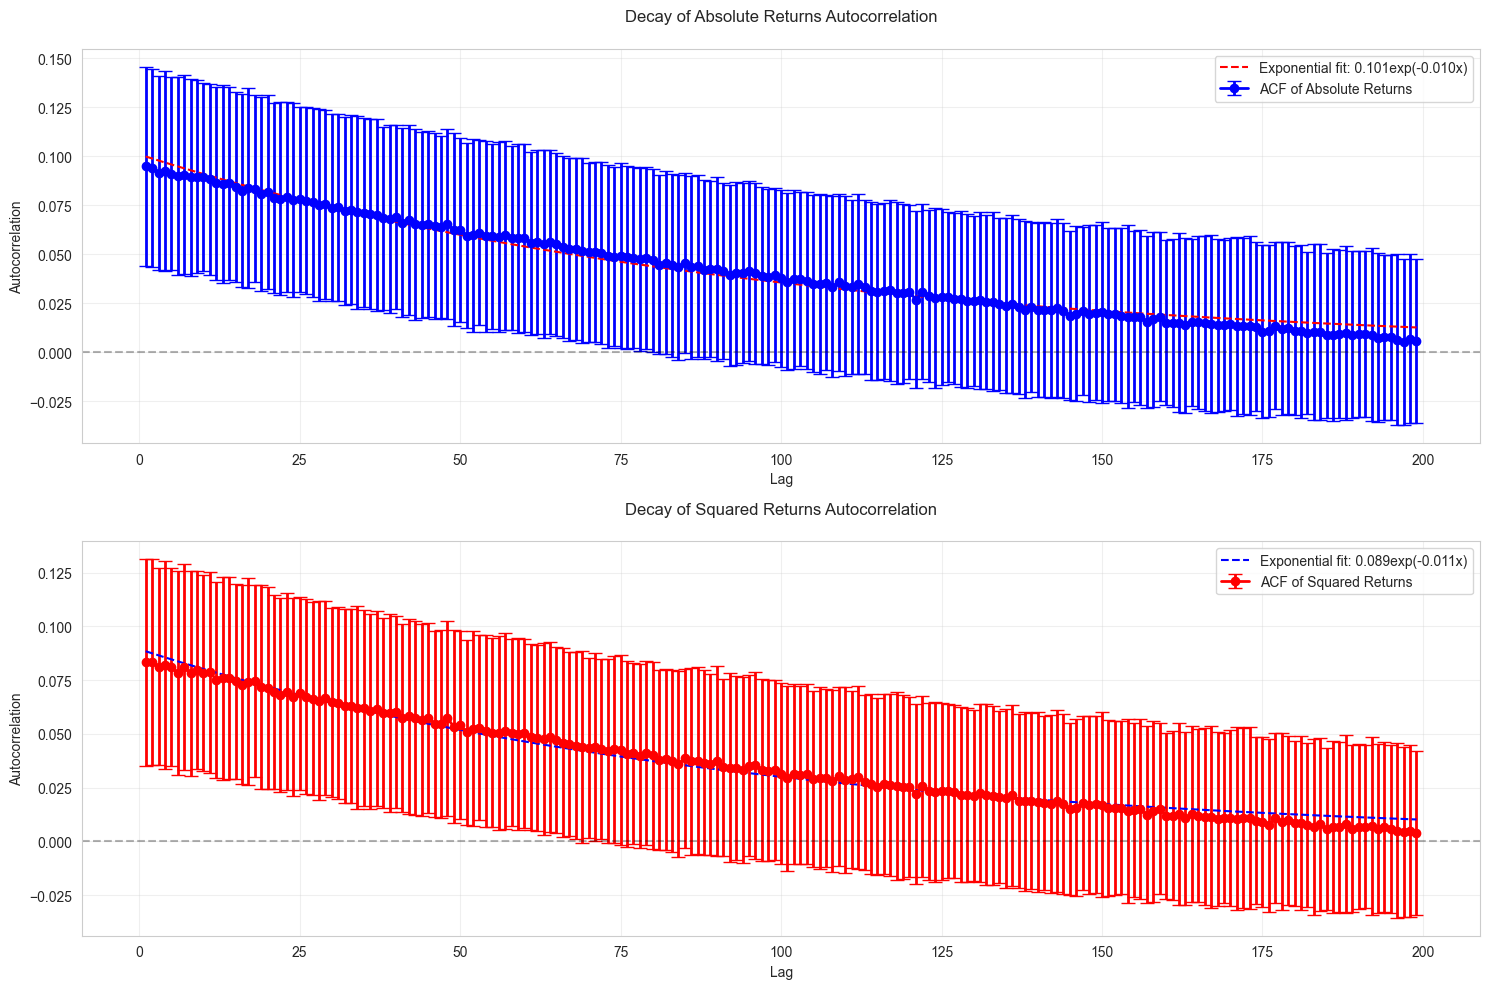

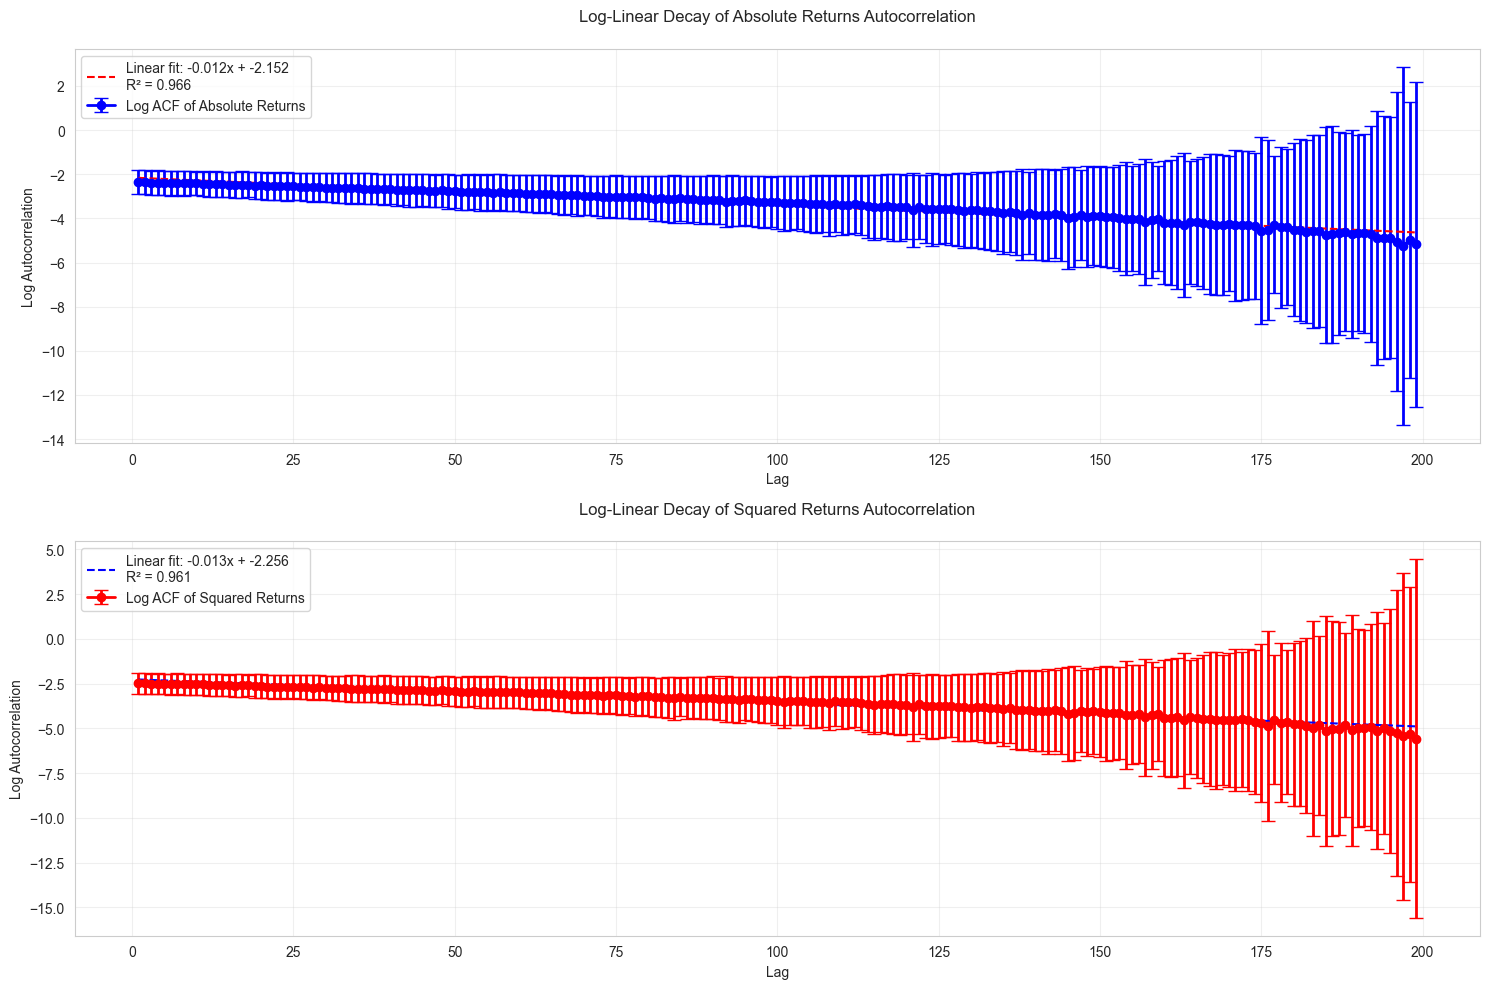


Volatility Clustering Decay Analysis:
Absolute Returns ACF:
Initial decay rate (lag 1): 0.095
Half-life (lag where ACF < 0.5): 1
Exponential decay rate: 0.010
Log-linear decay rate: -0.012
Log-linear R²: 0.966

Squared Returns ACF:
Initial decay rate (lag 1): 0.083
Half-life (lag where ACF < 0.5): 1
Exponential decay rate: 0.011
Log-linear decay rate: -0.013
Log-linear R²: 0.961


In [14]:
model.plot_volatility_decay(prices, T, N, lags=200)

In [19]:
def study_mean_reversion(model, T, N, variances):
    """Study and plot mean reversion characteristics."""
    # Analyze decay from different initial levels
    initial_levels = [0.01, 0.04, 0.09]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Better color scheme
    
    plt.figure(figsize=(12, 6))
    time_points = np.linspace(0, 1.0, 251)
    
    for v0, color in zip(initial_levels, colors):
        # Create temporary model with new initial variance
        params_temp = HestonParameters(
            kappa=model.params.kappa,
            theta=model.params.theta,
            sigma=model.params.sigma,
            rho=model.params.rho,
            v0=v0,
            mu=model.params.mu
        )
        model_temp = HestonModel(params_temp)
        
        # Simulate paths
        _, var_paths = model_temp.simulate_paths(100, T=1.0, N=250, M=1000, return_vol=True)
        
        # Calculate mean variance path
        mean_var = np.mean(var_paths, axis=0)
        std_var = np.std(var_paths, axis=0)
        
        # Plot mean and confidence bands
        plt.plot(time_points, mean_var, color=color, label=f'v0 = {v0:.2f}')
        plt.fill_between(time_points, 
                        mean_var - 2*std_var,
                        mean_var + 2*std_var,
                        alpha=0.2,
                        color=color)
    
    # Add reference line for long-term variance
    plt.axhline(y=model.params.theta, color='red', linestyle='--',
                label='Long-term variance (θ)')
    
    plt.title('Variance Mean Reversion')
    plt.xlabel('Time')
    plt.ylabel('Variance')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('../figures/mean_reversion.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Estimate mean reversion speed
    dt = T/N
    kappa_est = model.estimate_mean_reversion_speed(variances, dt)
    print(f"\nMean Reversion Analysis:")
    print(f"Estimated kappa: {kappa_est:.3f} (True kappa: {model.params.kappa:.3f})")
    print("Mean reversion plot saved as 'figures/mean_reversion.png'")

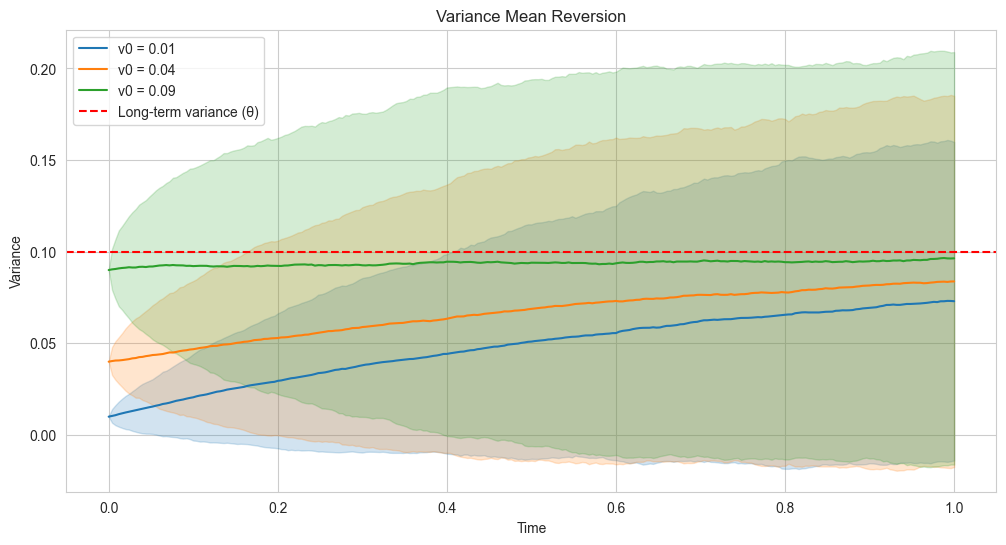

True mean reversion rate: f1.2
Extimated mean reversion rate from the simulated variance paths: f1.171909852323508

Mean Reversion Analysis:
Estimated kappa: 1.172 (True kappa: 1.200)
Mean reversion plot saved as 'figures/mean_reversion.png'


In [21]:
study_mean_reversion(model, T, N, variances)

In [22]:
model.estimate_mean_reversion_speed(variances, dt=T/N)

True mean reversion rate: f1.2
Extimated mean reversion rate from the simulated variance paths: f1.171909852323508


np.float64(1.171909852323508)

In [23]:
model.params.kappa

1.2

In [38]:
def analyze_parameter_sensitivity(base_params):
    """Analyze and plot sensitivity to different parameters."""
    def plot_sensitivity(base_params, param_name, values):
        plt.figure(figsize=(12, 6))
        
        colors = sns.color_palette("husl", len(values))
        for value, color in zip(values, colors):
            # Create new parameters with modified value
            param_dict = base_params.__dict__.copy()
            param_dict[param_name] = value
            new_params = HestonParameters(**param_dict)
            model = HestonModel(new_params)
            
            # Simulate and plot
            _, variances = model.simulate_paths(100, T=1.0, N=250, M=500, return_vol=True)
            mean_vol = np.sqrt(np.mean(variances, axis=0))
            time_points = np.linspace(0, 1.0, 251)
            
            plt.plot(time_points, mean_vol, label=f'{param_name}={value:.2f}', color=color)
        
        plt.title(f'Sensitivity to {param_name}')
        plt.xlabel('Time')
        plt.ylabel('Mean Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.savefig(f'../figures/sensitivity_{param_name}.png', dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Parameter sensitivity plot for {param_name} saved as 'figures/sensitivity_{param_name}.png'")
    
    print("\nAnalyzing parameter sensitivity...")
    # Test different parameter values
    plot_sensitivity(base_params, 'kappa', [1.0, 2.0, 3.0])
    plot_sensitivity(base_params, 'theta', [0.02, 0.04, 0.06])
    plot_sensitivity(base_params, 'sigma', [0.2, 0.3, 0.4])


Analyzing parameter sensitivity...


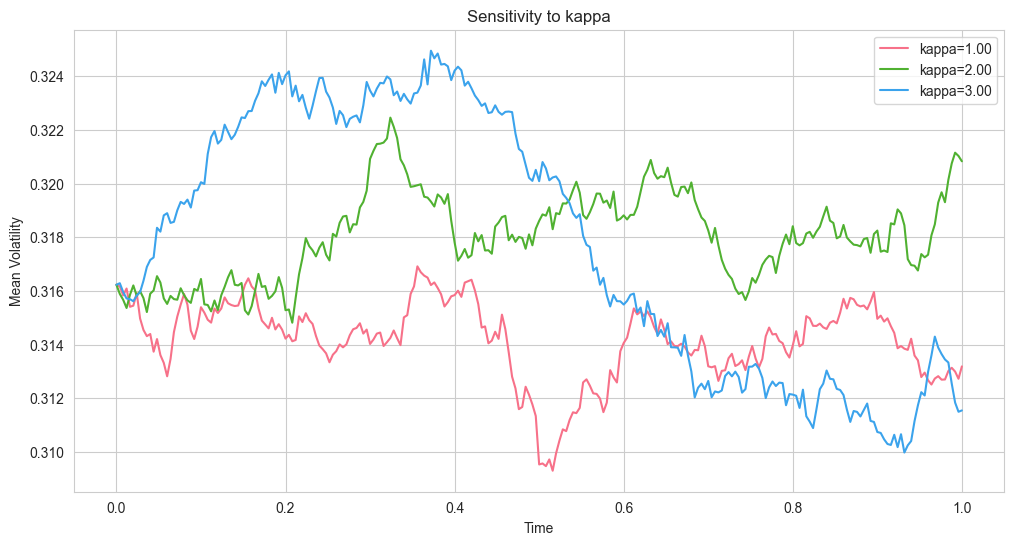

Parameter sensitivity plot for kappa saved as 'figures/sensitivity_kappa.png'


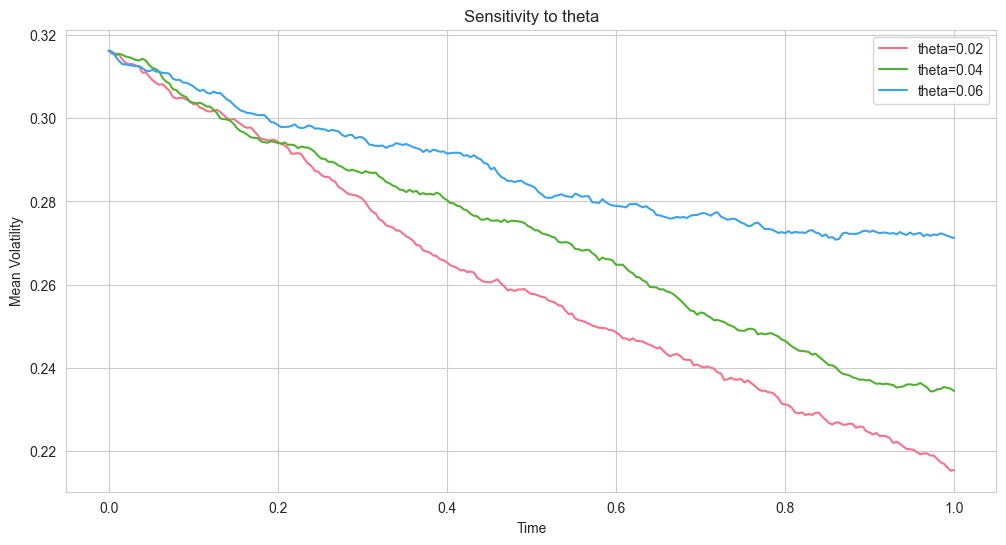

Parameter sensitivity plot for theta saved as 'figures/sensitivity_theta.png'


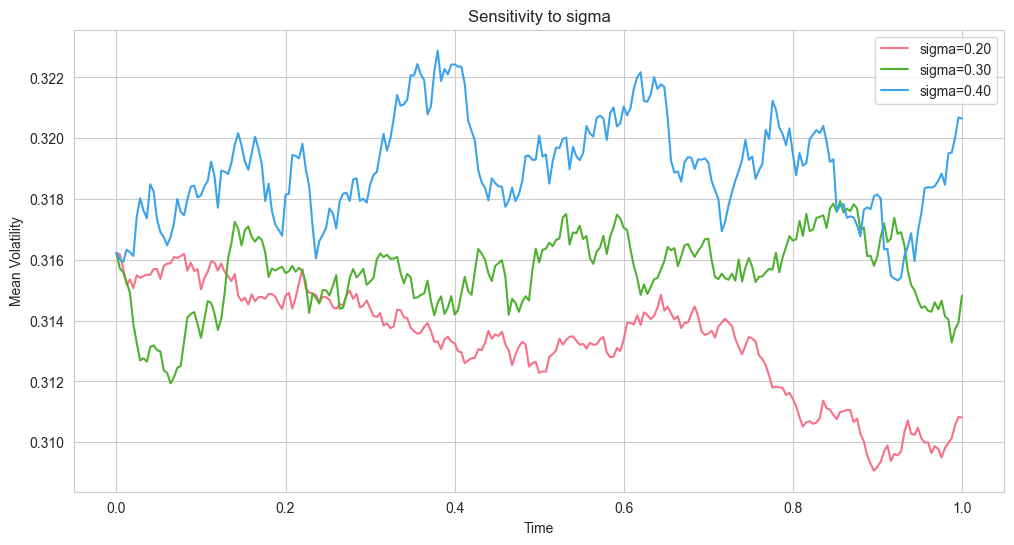

Parameter sensitivity plot for sigma saved as 'figures/sensitivity_sigma.png'


In [39]:
analyze_parameter_sensitivity(params)

## Option pricing under the Heston Medel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from heston_model import HestonModel, HestonParameters
from heston_pricing import HestonPricer, test_pricing

In [2]:
test_pricing()


Model Parameters:
kappa (mean reversion): 1.2
theta (long-term variance): 0.1
sigma (vol of vol): 0.3
rho (correlation): -0.8
v0 (initial variance): 0.1
mu (drift): 0.1

Option Parameters:
S0 (spot price): 100.0
K (strike price): 100.0
T (time to maturity): 1.0
r (risk-free rate): 0.05

Pricing with Heston Characteristic Function Method...
Call Price: 14.6375 ± -0.0000
Put Price: 9.7605 ± -0.0000

Implied Volatilities from Heston Prices:
Call IV: 0.3107
Put IV: 0.3107

Pricing with Black-Scholes Closed Form (using Heston IV)...
Call Price (using Call IV): 14.6375
Put Price (using Put IV): 9.7605

Pricing with Monte Carlo Method...

Heston MC Prices (10000 paths):
Call: 14.3121 ± 0.1921
Put: 9.9135 ± 0.1523

Black-Scholes MC Prices (10000 paths):
Call: 14.4245 ± 0.2283
Put: 9.8532 ± 0.1342

Heston MC Prices (50000 paths):
Call: 14.7491 ± 0.0877
Put: 9.7918 ± 0.0677

Black-Scholes MC Prices (50000 paths):
Call: 14.4916 ± 0.1032
Put: 9.7180 ± 0.0598

Heston MC Prices (100000 paths):
Call

In [2]:
# 1. Initialize model with parameters that strictly satisfy the Feller condition
# Feller: 2*kappa*theta > sigma^2 
params = HestonParameters(
    kappa=1.2,    # Moderate mean reversion
    theta=0.1,   # Long-term variance (32% volatility)
    sigma=0.3,    # Volatility of variance
    rho=-0.8,     # Strong leverage effect (more negative ρ implies a stronger leverage effect.)
    v0=0.1,      # Initial variance matching long-term level
    mu=0.05        # Drift rate
)


In [3]:
# Create model and pricer
model = HestonModel(params)
pricer = HestonPricer(model)